<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/marie_dev/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

[Errno 2] No such file or directory: '/root/.ssh/'
/content
Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:BUHsFrZt70D8gTcPwnxURHZCtEX9dkhdXiV9rYwZB5A root@5d42a3a94877
The key's randomart image is:
+---[RSA 4096]----+
|       o+..o.BX+%|
|        +.E o.oBB|
|       o B.o B.o+|
|        +.X O + +|
|       .So * = ..|
|          . o .  |
|           o     |
|            .    |
|                 |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-3c627260
/root/.ssh
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCqGPppVbBZ6eCMCLURI/fe/0jSNtf+jNExFOjM184EgmL274RcioMQDKZxDM7S2Ns3p1ly0guQhFoIhSlJcZUhS9sAAUcRrxU09GjixMCQDd7Z7J6a6WhwdzCEQe/U4NqFGIV5uT5K431g1ek0mltU4RiEsURZDtv/ayaatZ34HN9+am8hzSubWY6qdY/

In [19]:
%cd /content/drive/MyDrive/git/COMP551/projects/p2

[Errno 2] No such file or directory: '/content/drive/MyDrive/git/COMP551/projects/p2'
/root/.ssh


# **Mini-Project 2: Optimization and Text Classification**

## PART I: Optimization


In [10]:
import pandas as pd
import numpy as np
import time
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint
np.random.seed(1234)

### Logistic Regression

In [11]:
logistic = lambda z: 1./ (1 + np.exp(-z))   
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, batch_size=None, momentum=False, momentum_coefficient=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.batch_size = batch_size
        self.momentum = momentum

        if self.momentum:
          # array to store gradient of each time step
          self.gradients = [0] * max_iters
          self.momentum_coefficient = momentum_coefficient

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            g = self.stochastic_gradient(x, y, self.batch_size)

            if self.momentum:
              self.gradients[t] = g

            self.gradient_norm = np.linalg.norm(g)

            if self.momentum and t != 0:
              self.w = self.w -self.learning_rate * self.running_average(t)
            else:
              self.w = self.w - self.learning_rate * g 

            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))   # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def stochastic_gradient(self, x, y, batch_size=None):
        N = x.shape[0]
        if batch_size is None or batch_size > N:              # gradient on full data by default
          batch_size = N
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:batch_size,:]
        y_batch = y[inds][:batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/batch_size
        return stoch_grad

    def running_average(self, t):
      running_average = 0
      for i in range(1,t+1):
          running_average += (self.momentum_coefficient ** (t-i)) * (1-self.momentum_coefficient) * self.gradients[i]
      return running_average


### Cost Function

In [12]:
def cost_fn(y, yh):
    return y[y != yh].size/y.size

### Gradient Descent Hyper-Parameter Tuning

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [13]:
def gd_hypertuning_plots(param_range_type='lr', param_range=None, max_iters_range=np.arange(0,100,1), x_train=None, y_train=None, x_val=None, y_val=None, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None):
  '''
  param_range_type: the code of the parameter we want to tune. 
                    'lr': learning rate
                    'bs': batch size
                    'mc': momentum coefficient

  param_range: the range of the param we want to tune

  max_iters_range: the rage of number of gradient descent iterations

  x_train, y_train, x_val, y_val: the data

  reg_type: type of regression to use

  lr: fixed learning rate to use when tuning other parameters

  batch_size: fixed batch size to use when tuning other parameters

  momentum: indicates if momentum gradient descent is used 

  momentum_coefficient: fixed momentum coefficient to use when tuning other parameters
  '''
  
  # setup figures and axis
  figure, axis = plt.subplots(4, 1)
  figure.set_figheight(10)
  figure.set_figwidth(10)
  figure.tight_layout(pad=5.0)

  # figure title
  if param_range_type == 'lr':
    param_name = 'Learning Rate'
  elif param_range_type == 'bs':
    param_name = 'Batch Size'
  elif param_range_type == 'mc':
    param_name = 'Momentum Coefficient'

  figure.suptitle('Convergence of Gradient Descent Solution for Different {param}'.format(param=param_name), fontsize=16)
  axis[0].set_title("Train Accuracy")
  axis[0].set_ylabel("Accuracy")

  axis[1].set_title("Validation Accuracy")
  axis[1].set_ylabel("Accuracy")

  axis[2].set_title("Gradient Norm")
  axis[2].set_ylabel("Gradient Norm")

  axis[3].set_title("Execution Time")
  axis[3].set_ylabel("Time")

  best_train_acc, best_val_acc = {'value':0, 'max_iters':0, 'param':0}, {'value':0, 'max_iters':0, 'param':0}
  for i,  param in enumerate(param_range):
    
    # setup param we want to tune
    if param_range_type == 'lr':
      lr = param
    elif param_range_type == 'bs':
      batch_size = param
    elif param_range_type == 'mc':
      momentum_coefficient = param

    # y axis ranges
    acc_train_arr = np.zeros((max_iters_range.size))
    acc_val_arr = np.zeros((max_iters_range.size))
    g_norm_arr = np.zeros((max_iters_range.size))
    time_arr = np.zeros((max_iters_range.size))

    for j, max_iters in enumerate(max_iters_range):
      t0 = time.time()
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-4, max_iters=max_iters, verbose=False, batch_size=batch_size, momentum=momentum, momentum_coefficient=momentum_coefficient)
      reg.fit(x_train, y_train)

      # compute error
      yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
      t1 = time.time()
      time_arr[j] = t1 - t0
      y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
      acc_train_arr[j], acc_val_arr[j] = 1 - cost_fn(y_pred_train, y_train), 1 - cost_fn(y_pred_val, y_val)
      g_norm_arr[j] = reg.gradient_norm

    # keep track of best accuracies found
    cur_best_train_acc, cur_best_val_acc = np.max(acc_train_arr), np.max(acc_val_arr)
    if cur_best_train_acc > best_train_acc['value']:
      best_train_acc['value'] = cur_best_train_acc
      best_train_acc['max_iters'] = max_iters_range[np.argmax(acc_train_arr)]
      best_train_acc['param'] = param

    if cur_best_val_acc > best_val_acc['value']:
      best_val_acc['value'] = cur_best_val_acc
      best_val_acc['max_iters'] = max_iters_range[np.argmax(acc_val_arr)]
      best_val_acc['param'] = param

    # add plot lines
    axis[0].plot(max_iters_range, acc_train_arr, label="%0.6f" % param)
    axis[1].plot(max_iters_range, acc_val_arr, label="%0.6f" % param)
    axis[2].plot(max_iters_range, g_norm_arr, label="%0.6f" % param)
    axis[3].plot(max_iters_range, time_arr, label="%0.6f" % param)

  print("Best train accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=best_train_acc['value'], param_name=param_name, param=best_train_acc['param'], max_iters=best_train_acc['max_iters']))
  print("Best validation accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=best_val_acc['value'], param_name=param_name, param=best_val_acc['param'], max_iters=best_val_acc['max_iters']))

  for i, subplot in enumerate(axis):
    subplot.set_xlabel("Number of Iterations")
    subplot.legend()
  plt.show()



### 1. Import Data

In [20]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'), pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

FileNotFoundError: ignored

### 2. Learning Rate and Number of Iterations Tuning

The learning rate and the max number of iterations will be determined empirically. We will start by high learning rates. The accuracy per number of iterations will be plot for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


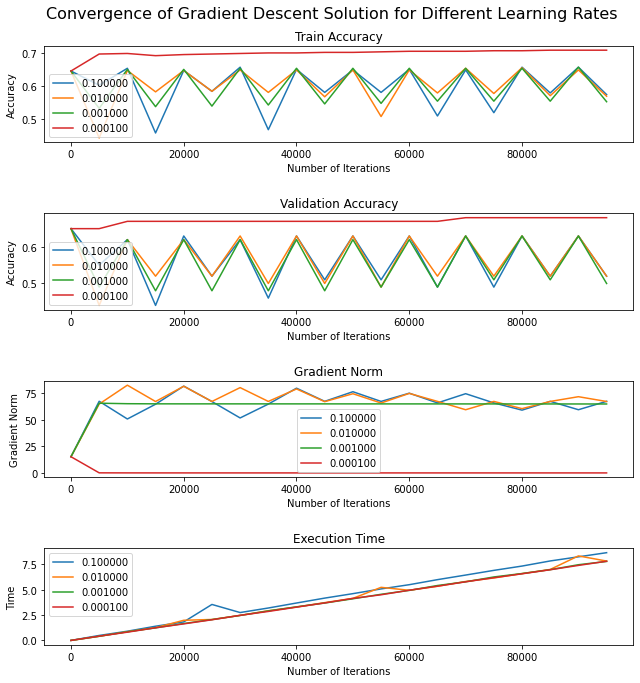

In [ ]:
lr_range = np.array([0.1,0.01,0.001, 0.0001])
max_iters_range = np.arange(1,100000,5001)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

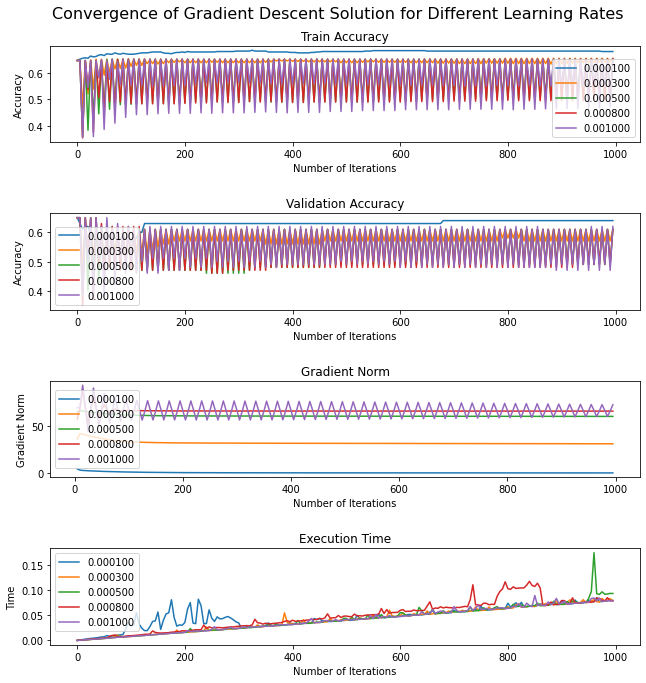

In [ ]:
lr_range = np.array([0.0001,0.0003, 0.0005, 0.0008, 0.001])
max_iters_range = np.arange(0,1000,5)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

Best train accuracy: 0.6866666666666666
Learning Rate: 0.00025
Number of iterations: 835

Best validation accuracy: 0.65
Learning Rate: 0.00025
Number of iterations: 880



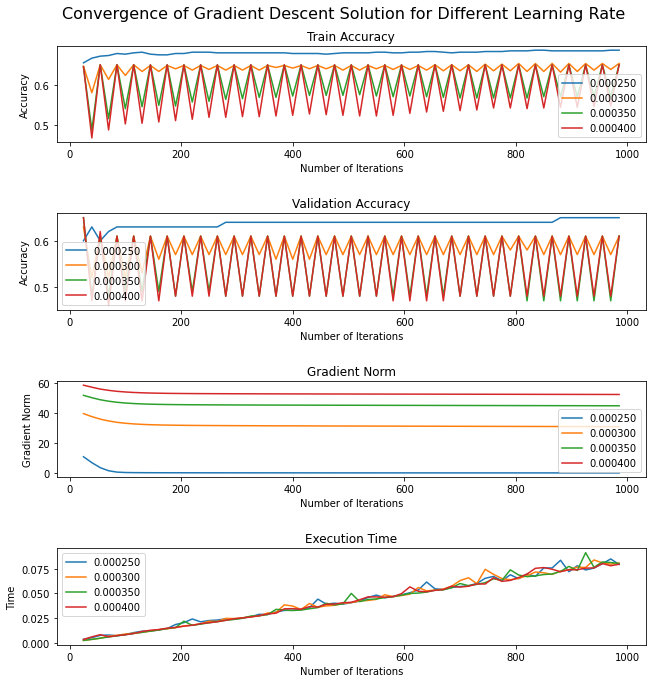

In [ ]:
lr_range = np.array([0.00025, 0.0003, 0.00035, 0.0004])
max_iters_range = np.arange(25,1000,15)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

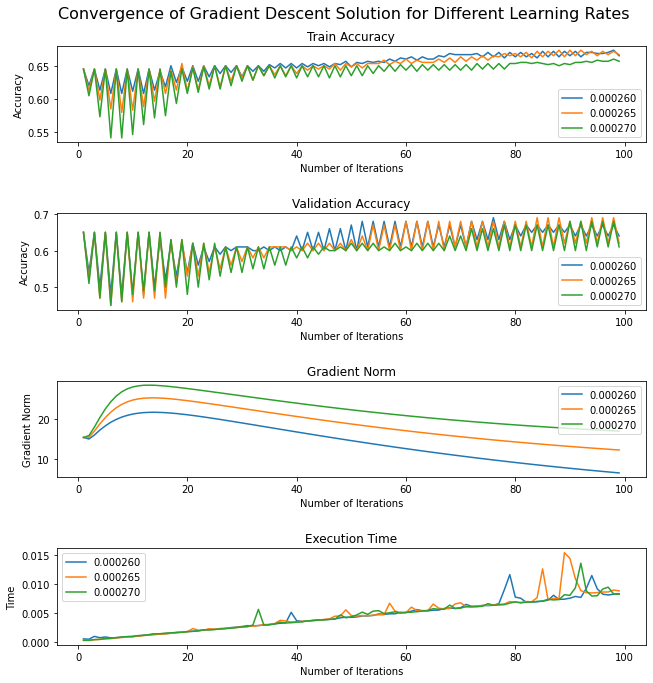

In [ ]:
lr_range = np.array([0.00026,0.000265, 0.00027])
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

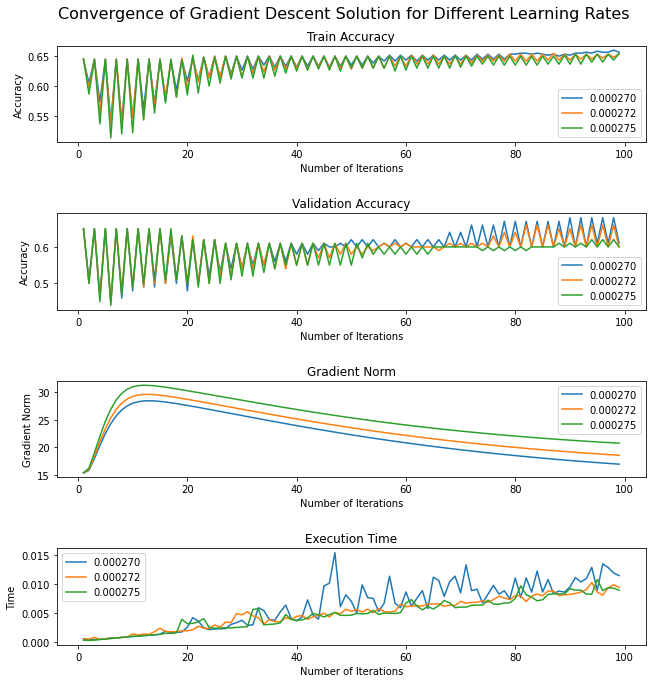

In [ ]:
lr_range = np.array([0.00027,.000272, 0.000275])
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

### Results:

From the empirically testing, we decided to use a learning rate of 0.000271 and a maximum number of iterations of 3 000 000.

In [ ]:
lr = 0.001
max_iters = 1000000
epsilon = 0.0001

reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True)
reg.fit(x_train, y_train)

# compute error
yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
acc_train, acc_val = 1 - cost_fn(y_pred_train, y_train), 1 - cost_fn(y_pred_val, y_val)

print("train accuracy: {acc_train}".format(acc_train=acc_train))
print("validation accuracy: {acc_val}".format(acc_val=acc_val))

terminated after 1000000 iterations, with norm of the gradient equal to 54.842098804213606
the weight found: [ 5.05983158e-01  1.21525388e-01 -3.96970355e-02 -1.72448126e-02
  2.46974260e-02  1.70477435e-01  2.26760521e+00  2.36794237e-02
 -1.98271150e+01]
train accuracy: 0.6366666666666667
validation accuracy: 0.63


## 3. Mini-batch Sochastic Gradient

Analyze effect of varying the batch size on the convergence.

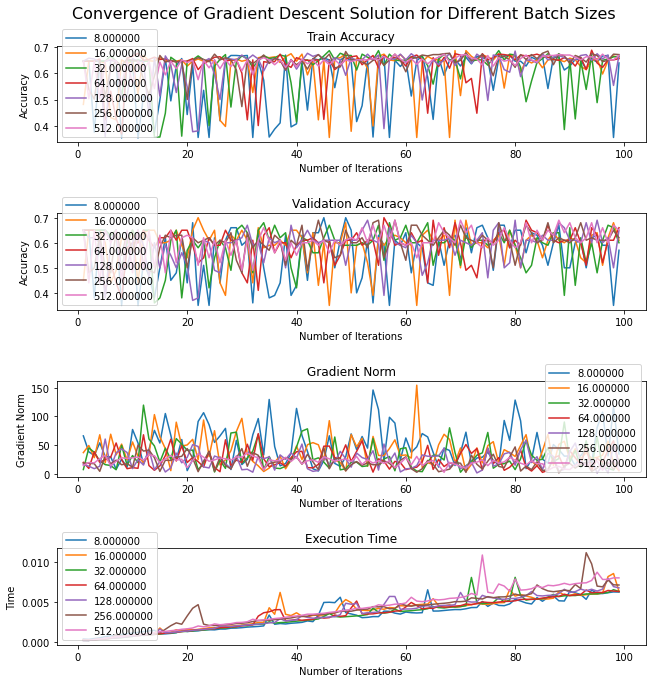

In [ ]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512]

max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'bs', param_range = batch_size_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=False, momentum_coefficient=None)

## 4. Gradient Descent with Momentum

Vary the momentum coefficient and check effect on convergence speed.

No batch size --> full data

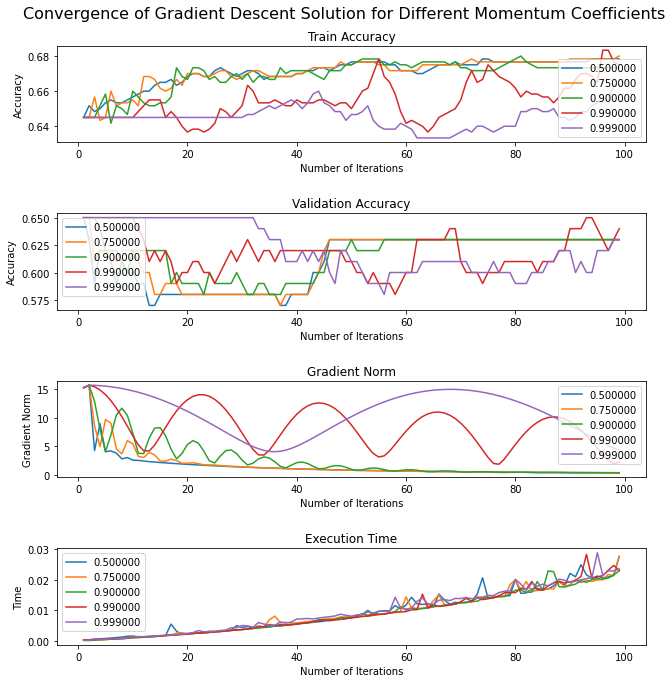

In [ ]:
momentum_coefficient_range = [0.5, 0.75, 0.9, 0.99, 0.999]
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=True, momentum_coefficient=None)

SyntaxError: ignored